In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import Parallel, delayed

In [2]:
df = pd.read_csv("C:/Users/divya/Desktop/conestoga/predictive analytics/sem 2/Statistical Application for Data analytics/Group project 2/Walmart_Sales.csv",parse_dates=['Date'], dayfirst= True)
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


# Inspect the data and data preprocessing part

In [3]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [6]:
df['Date']

0      2010-02-05
1      2010-02-12
2      2010-02-19
3      2010-02-26
4      2010-03-05
          ...    
6430   2012-09-28
6431   2012-10-05
6432   2012-10-12
6433   2012-10-19
6434   2012-10-26
Name: Date, Length: 6435, dtype: datetime64[ns]

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
# filtering a data of store 7 only
df = df[df['Store'] == 7]
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,7,496725.44,0,10.53,2.580,189.381697,9.014
2010-02-12,7,524104.92,1,25.90,2.572,189.464272,9.014
2010-02-19,7,506760.54,0,27.28,2.550,189.534100,9.014
2010-02-26,7,496083.24,0,24.91,2.586,189.601802,9.014
2010-03-05,7,491419.55,0,35.86,2.620,189.669505,9.014
...,...,...,...,...,...,...,...
2012-09-28,7,525545.76,0,50.64,3.789,198.590328,7.872
2012-10-05,7,505830.56,0,48.43,3.779,198.822132,7.557
2012-10-12,7,503463.93,0,41.43,3.760,199.053937,7.557


In [9]:
# to see colomns and index
print(df.columns) 
print(df.index)    

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')
DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)


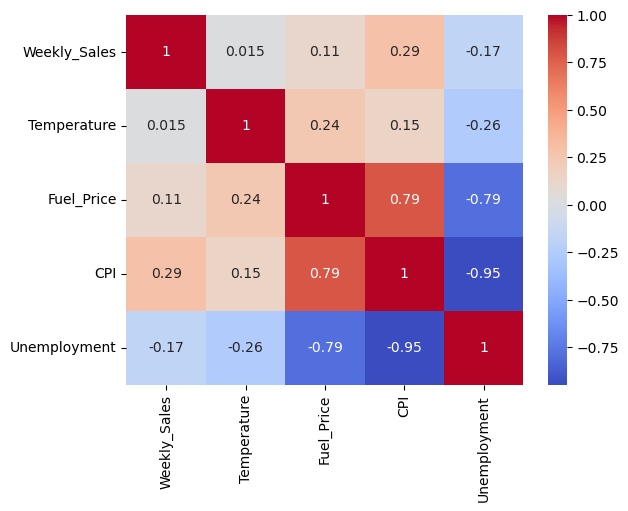

In [10]:
correlation = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

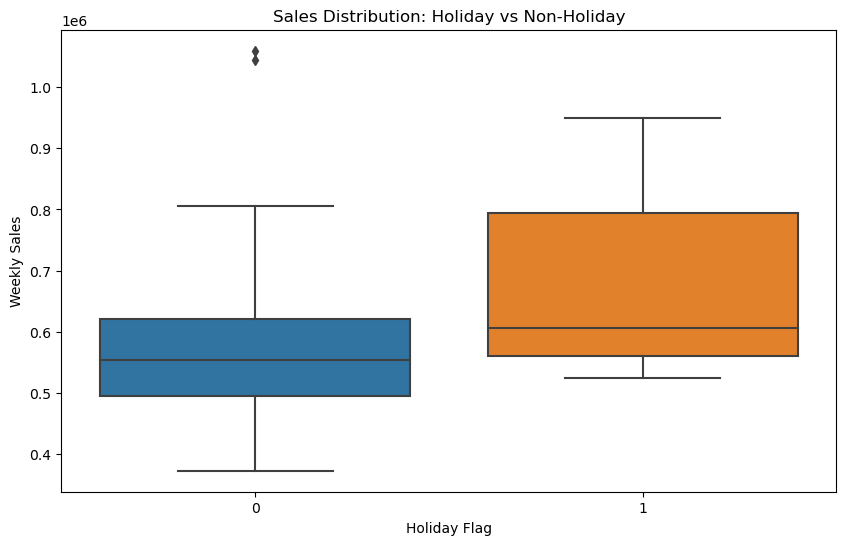

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.show()

C:\Users\divya\AppData\Local\Temp\ipykernel_12384\3005774883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rolling_Mean'] = df['Weekly_Sales'].rolling(window=4).mean()
C:\Users\divya\AppData\Local\Temp\ipykernel_12384\3005774883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rolling_Std'] = df['Weekly_Sales'].rolling(window=4).std()


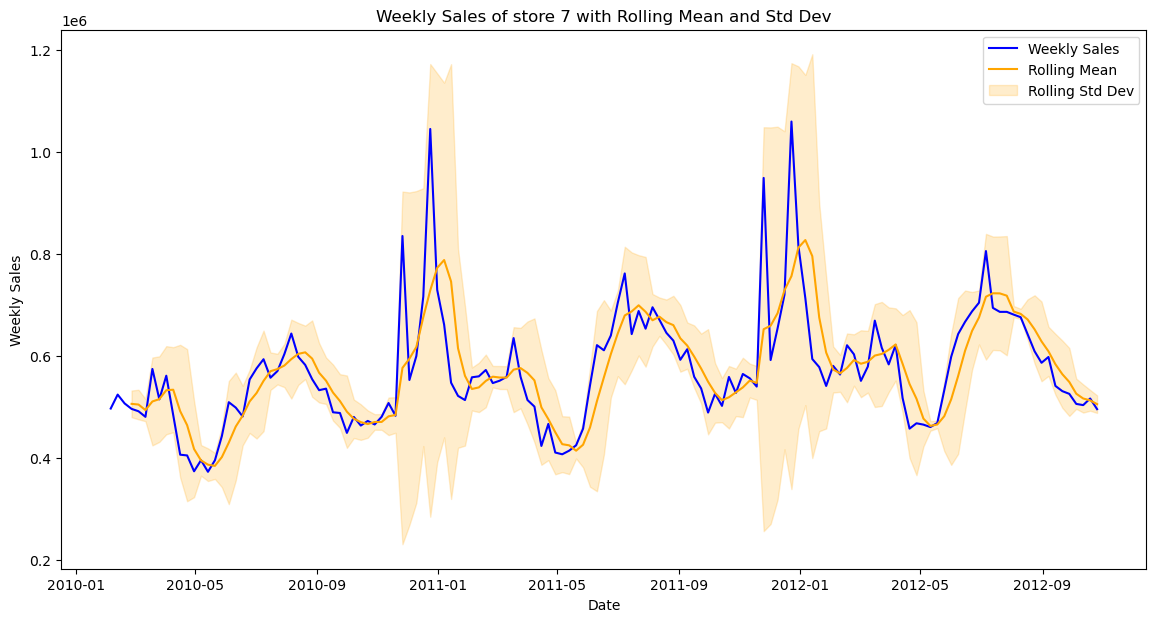

In [12]:
# Calculating rolling mean and standard deviation
df['Rolling_Mean'] = df['Weekly_Sales'].rolling(window=4).mean()
df['Rolling_Std'] = df['Weekly_Sales'].rolling(window=4).std()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.plot(df.index, df['Rolling_Mean'], label='Rolling Mean', color='orange')
plt.fill_between(df.index, df['Rolling_Mean'] - 2 * df['Rolling_Std'], df['Rolling_Mean'] + 2 * df['Rolling_Std'], color='orange', alpha=0.2, label='Rolling Std Dev')
plt.title('Weekly Sales of store 7 with Rolling Mean and Std Dev')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


C:\Users\divya\AppData\Local\Temp\ipykernel_12384\3614375871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z_Score'] = stats.zscore(df['Weekly_Sales'])


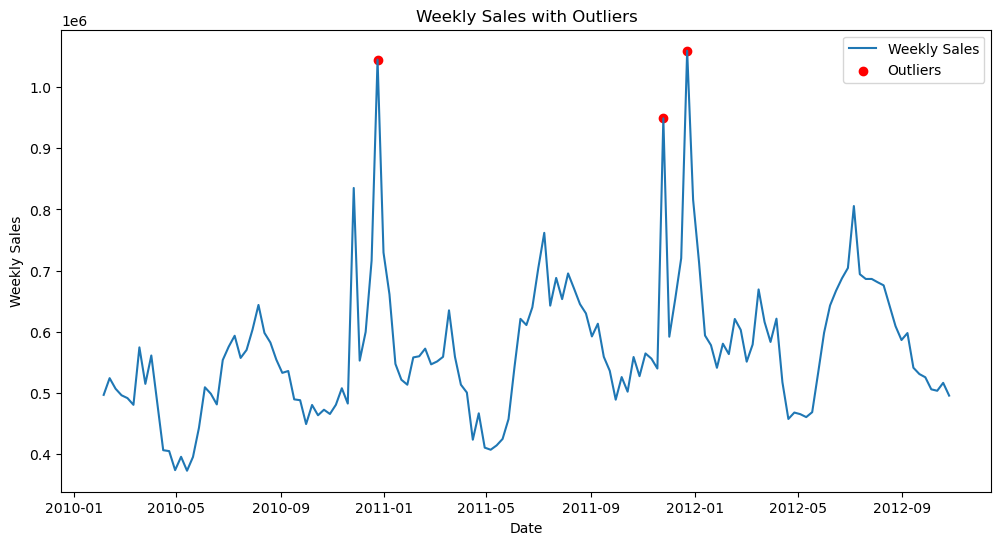

In [13]:
# Calculate Z-score to detect outliers 
df['Z_Score'] = stats.zscore(df['Weekly_Sales'])
outliers = df[df['Z_Score'].abs() > 3]  

# Plotting outliers and time series graph
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Weekly_Sales'], label='Weekly Sales')
plt.scatter(outliers.index, outliers['Weekly_Sales'], color='red', label='Outliers')
plt.title('Weekly Sales with Outliers')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

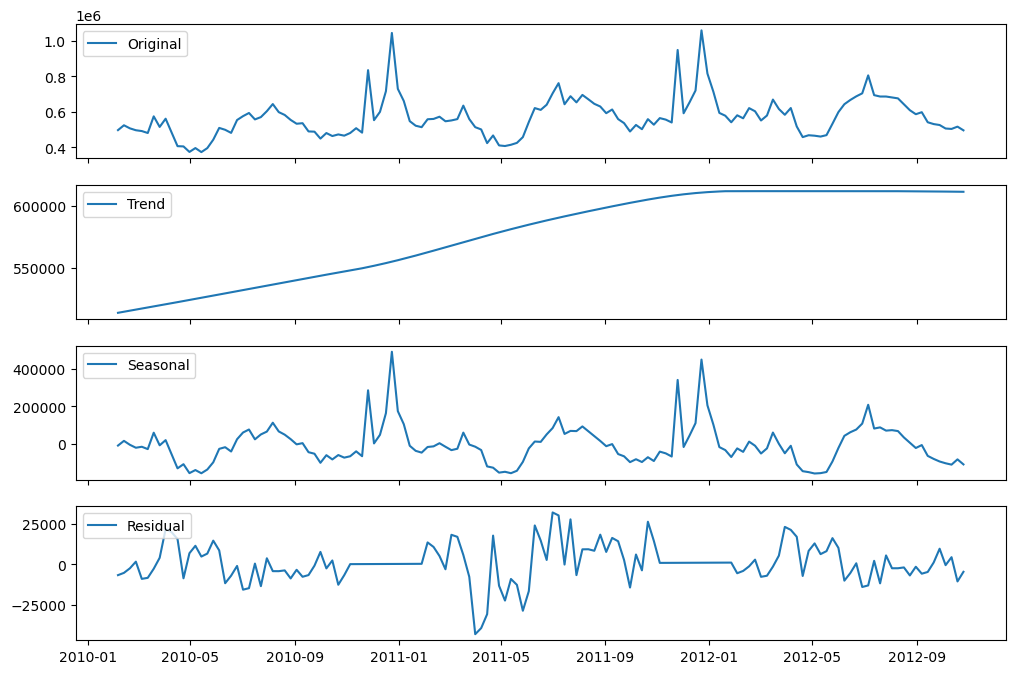

In [14]:
# STL decomposition
stl = STL(df['Weekly_Sales'], seasonal=53)
result = stl.fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
ax1.plot(df['Weekly_Sales'], label='Original')
ax1.legend(loc='upper left')
ax2.plot(result.trend, label='Trend')
ax2.legend(loc='upper left')
ax3.plot(result.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax4.plot(result.resid, label='Residual')
ax4.legend(loc='upper left')
plt.show()


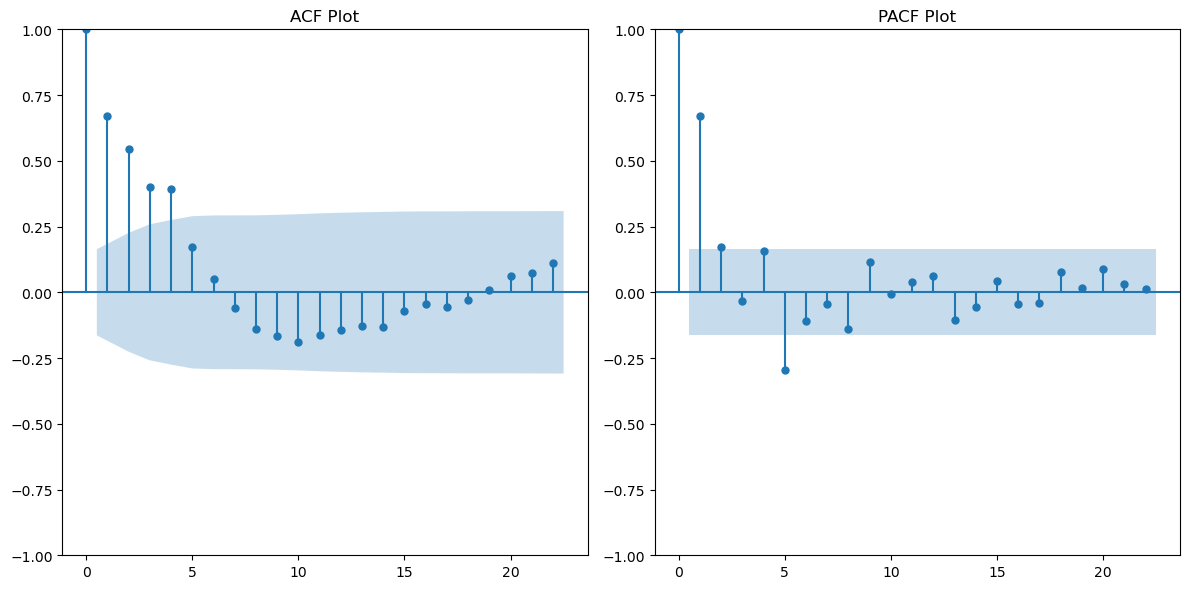

In [15]:
# Ploting ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df['Weekly_Sales'], ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df['Weekly_Sales'], ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [16]:
# Perform ADF test for stationarity checking
result = adfuller(df['Weekly_Sales'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


if result[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -4.476254338547259
p-value: 0.0002170071890711737
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}
The time series is likely stationary.


# Model building and training

In [17]:
# Split the data into training and testing sets
train_df = df[df.index.year < 2012]
test_df = df[df.index.year >= 2012]

ETS model


Testing combination: Trend=add, Seasonal=add, Seasonal_Periods=52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 15525.52
Root Mean Squared Error (RMSE): 25299.56

Testing combination: Trend=add, Seasonal=mul, Seasonal_Periods=52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 15560.12
Root Mean Squared Error (RMSE): 24790.32

Testing combination: Trend=mul, Seasonal=add, Seasonal_Periods=52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 15557.20
Root Mean Squared Error (RMSE): 25337.87

Testing combination: Trend=mul, Seasonal=mul, Seasonal_Periods=52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 15575.32
Root Mean Squared Error (RMSE): 24831.22

Best combination: Trend=add, Seasonal=mul, Seasonal_Periods=52
Best RMSE: 24790.32


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



Summary of the Best Model:
                       ExponentialSmoothing Model Results                       
Dep. Variable:             Weekly_Sales   No. Observations:                  143
Model:             ExponentialSmoothing   SSE                    87882069504.405
Optimized:                         True   AIC                           3005.808
Trend:                         Additive   BIC                           3171.727
Seasonal:                Multiplicative   AICC                          3087.284
Seasonal Periods:                    52   Date:                 Mon, 28 Oct 2024
Box-Cox:                          False   Time:                         21:28:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 Tr

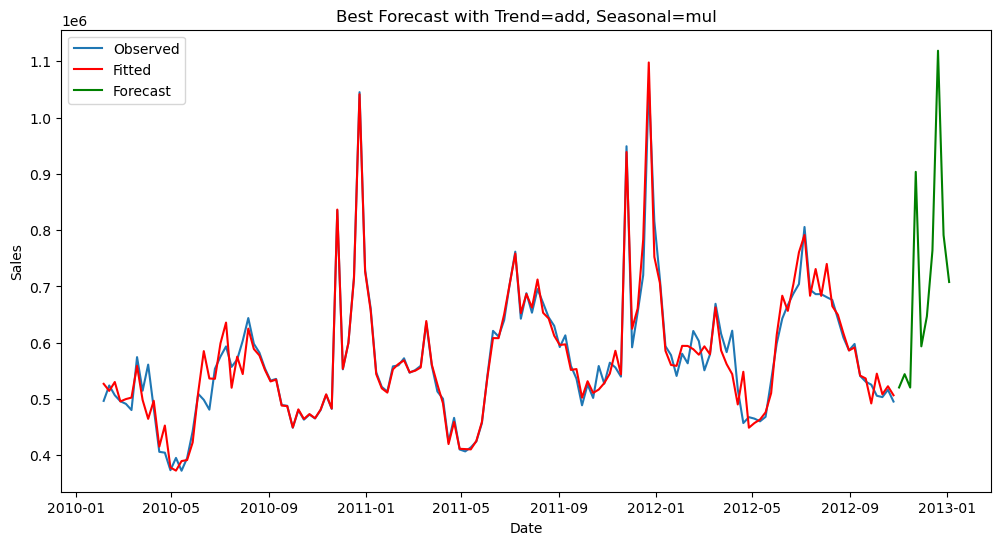

In [18]:
def fit_ets_model(df, trend, seasonal, seasonal_periods):
    model = sm.tsa.ExponentialSmoothing(df['Weekly_Sales'],
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods)
    fit_model = model.fit()
    fitted_values = fit_model.fittedvalues
    
    mae = mean_absolute_error(df['Weekly_Sales'].dropna(), fitted_values)
    mse = mean_squared_error(df['Weekly_Sales'].dropna(), fitted_values)
    rmse = np.sqrt(mse)
    
    return fit_model, mae, rmse

def plot_results(df, fitted_values, forecast, title='Retail Sales Forecast'):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Weekly_Sales'], label='Observed')
    plt.plot(fitted_values.index, fitted_values, label='Fitted', color='red')
    plt.plot(forecast.index, forecast, label='Forecast', color='green')
    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Define parameter combinations
param_combinations = [
    ('add', 'add', 52),
    ('add', 'mul', 52),
    ('mul', 'add', 52),
    ('mul', 'mul', 52),
]

best_rmse = float('inf')
best_combination = None
best_model = None

for trend, seasonal, seasonal_periods in param_combinations:
    print(f"\nTesting combination: Trend={trend}, Seasonal={seasonal}, Seasonal_Periods={seasonal_periods}")
    
    model, mae, rmse = fit_ets_model(df, trend, seasonal, seasonal_periods)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_combination = (trend, seasonal, seasonal_periods)
        best_model = model  # Store the model object, not the summary

print(f"\nBest combination: Trend={best_combination[0]}, Seasonal={best_combination[1]}, Seasonal_Periods={best_combination[2]}")
print(f"Best RMSE: {best_rmse:.2f}")

best_trend, best_seasonal, best_seasonal_periods = best_combination
best_model = sm.tsa.ExponentialSmoothing(df['Weekly_Sales'],
                                         trend=best_trend,
                                         seasonal=best_seasonal,
                                         seasonal_periods=best_seasonal_periods).fit()

print("\nSummary of the Best Model:")
print(best_model.summary())

forecast = best_model.forecast(steps=10)

plot_results(df, best_model.fittedvalues, forecast, title=f'Best Forecast with Trend={best_trend}, Seasonal={best_seasonal}')

ARIMA Model


Testing combination: ARIMA(3, 0, 5)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 51686.10
Root Mean Squared Error (RMSE): 81906.21

Testing combination: ARIMA(2, 0, 5)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 51825.99
Root Mean Squared Error (RMSE): 82100.90

Testing combination: ARIMA(3, 1, 5)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 60430.45
Root Mean Squared Error (RMSE): 101009.10

Testing combination: ARIMA(2, 1, 5)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 61951.01
Root Mean Squared Error (RMSE): 101677.72

Testing combination: ARIMA(2, 0, 4)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 51820.92
Root Mean Squared Error (RMSE): 82097.46

Testing combination: ARIMA(3, 1, 4)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 63103.85
Root Mean Squared Error (RMSE): 103140.95

Best combination: ARIMA(3, 0, 5)
Best RMSE: 81906.21
                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                 ARIMA(3, 0, 5)   Log Likelihood               -1274.613
Date:                Mon, 28 Oct 2024   AIC                           2569.227
Time:                        21:28:42   BIC                           2595.279
Sample:                    02-05-2010   HQIC                          2579.771
                         - 12-30-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.623e+05   3.37e+04     16.670      0.000    4.96e+05    6.28e+05

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


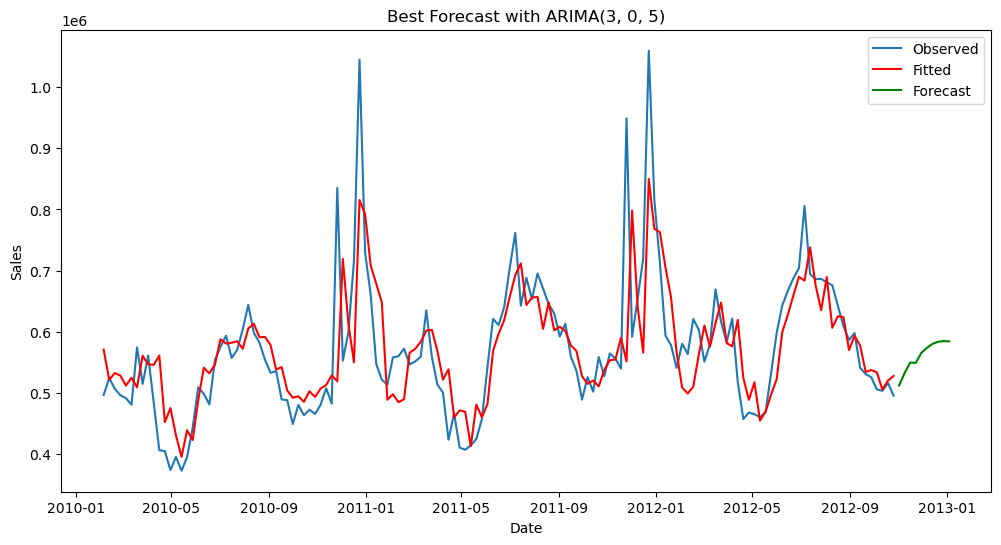

In [19]:
def fit_arima_model(train_df, order):
    model = sm.tsa.ARIMA(train_df['Weekly_Sales'], order = order)
    fit_model = model.fit()
    
    fitted_values = fit_model.fittedvalues
    
    mae = mean_absolute_error(train_df['Weekly_Sales'].dropna(), fitted_values)
    mse = mean_squared_error(train_df['Weekly_Sales'].dropna(), fitted_values)
    rmse = np.sqrt(mse)
    
    model_summary = fit_model.summary()
    
    return model_summary, mae, rmse, fit_model

def plot_results(df, fitted_values, forecast, title='Retail Sales Forecast'):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Weekly_Sales'], label='Observed')
    plt.plot(fitted_values.index, fitted_values, label='Fitted', color='red')
    plt.plot(forecast.index, forecast, label='Forecast', color='green')
    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Defining parameter combinations for ARIMA (p, d, q)
param_combinations = [
    (3,0,5),
    (2,0,5),
    (3,1,5),
    (2,1,5),
    (2,0,4),
    (3,1,4)
]

best_rmse = float('inf')
best_combination = None
best_model = None

for order in param_combinations:
    print(f"\nTesting combination: ARIMA{order}")
    
    model_summary, mae, rmse, fit_model = fit_arima_model(train_df, order)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # Updating the best combination if the current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_combination = order
        best_model = fit_model
        best_model_summary = model_summary

print(f"\nBest combination: ARIMA{best_combination}")
print(f"Best RMSE: {best_rmse:.2f}")
print(best_model_summary)

best_order = best_combination
best_model = sm.tsa.ARIMA(df['Weekly_Sales'], order=best_order).fit()

# Forecasting next 10 weeks
forecast = best_model.forecast(steps=10)

plot_results(df, best_model.fittedvalues, forecast, title=f'Best Forecast with ARIMA{best_order}')

SARIMA Model

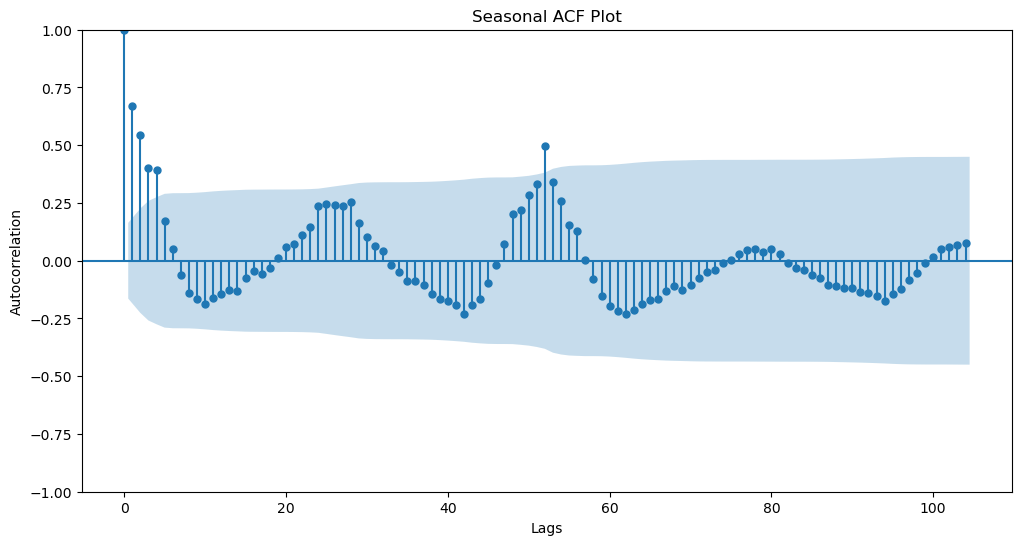

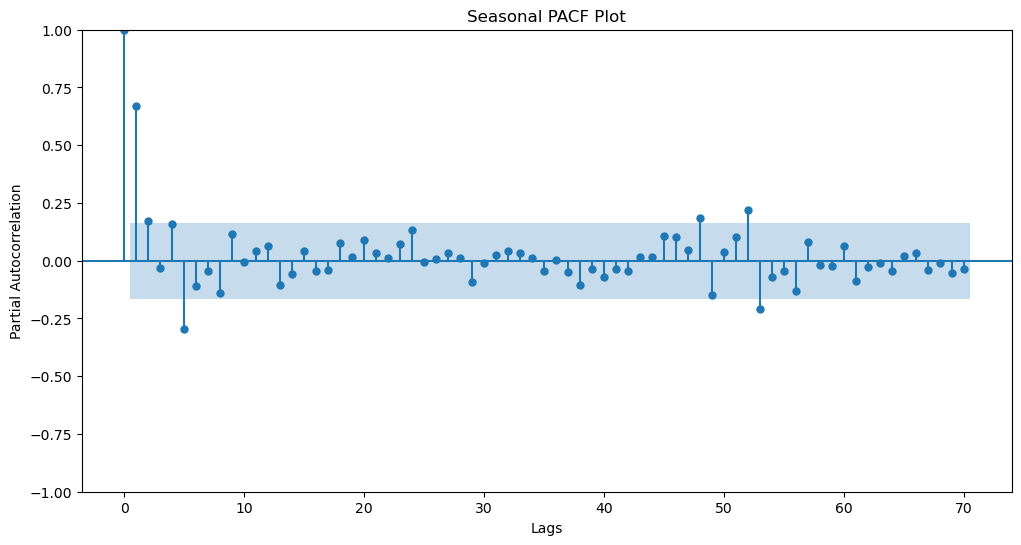

In [20]:
seasonal_period = 52

# Determine the max. number of lags that can be used for PACF
max_lags = len(df['Weekly_Sales']) // 2 - 1

# Setting lags for ACF and PACF to include seasonal multiples
acf_lags = 2 * seasonal_period  
pacf_lags = min(acf_lags, max_lags) 

plt.figure(figsize=(12, 6))
plot_acf(df['Weekly_Sales'], lags=acf_lags, ax=plt.gca())
plt.title('Seasonal ACF Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Weekly_Sales'], lags=pacf_lags, ax=plt.gca())
plt.title('Seasonal PACF Plot')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

ARIMA(2, 0, 5) with Seasonal Order (1, 0, 2, 52)
MAE: 46937.28
RMSE: 84859.76

ARIMA(2, 0, 5) with Seasonal Order (2, 0, 2, 52)
MAE: 47056.99
RMSE: 84854.17

ARIMA(2, 1, 5) with Seasonal Order (1, 0, 2, 52)
MAE: 54540.29
RMSE: 92543.05

ARIMA(2, 1, 5) with Seasonal Order (2, 0, 2, 52)
MAE: 54541.47
RMSE: 92543.67


Best combination: ARIMA(2, 0, 5) with Seasonal Order (1, 0, 2, 52)
Best MAE: 46937.28
Best RMSE: 84859.76


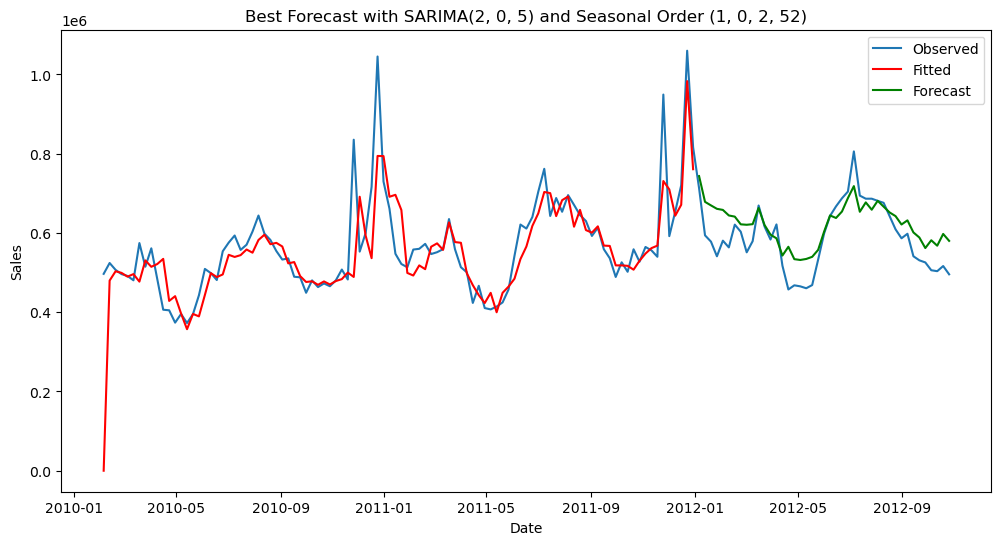

In [21]:
warnings.filterwarnings('ignore')

def fit_sarima_model(train_df, order, seasonal_order, forecast_steps):
    model = sm.tsa.SARIMAX(train_df['Weekly_Sales'], order=order, seasonal_order=seasonal_order)
    fit_model = model.fit(disp=False)
    
    fitted_values = fit_model.fittedvalues
    
    forecast = fit_model.get_forecast(steps=forecast_steps).predicted_mean
    
    # Calculate MAE and RMSE
    mae = mean_absolute_error(train_df['Weekly_Sales'].dropna(), fitted_values)
    mse = mean_squared_error(train_df['Weekly_Sales'].dropna(), fitted_values)
    rmse = np.sqrt(mse)
    
    return mae, rmse, fit_model, forecast

def plot_results(df, fitted_values, forecast, title='Retail Sales Forecast'):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Weekly_Sales'], label='Observed')
    plt.plot(fitted_values.index, fitted_values, label='Fitted', color='red')
    plt.plot(forecast.index, forecast, label='Forecast', color='green')
    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

parameter_combinations = [

    (2, 0, 5),
    (2, 1, 5),
]

seasonal_orders = [
    
    (1, 0, 2, 52),
    (2, 0, 2, 52)
]

forecast_steps = len(test_df)

def evaluate_model(order, seasonal_order):
    mae, rmse, fit_model, forecast = fit_sarima_model(train_df, order, seasonal_order, forecast_steps)
    return mae, rmse, order, seasonal_order, fit_model, forecast

# Parallel processing of models
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(order, seasonal_order) 
                               for order in parameter_combinations 
                               for seasonal_order in seasonal_orders)

for result in results:
    mae, rmse, order, seasonal_order, _, _ = result
    print(f"ARIMA{order} with Seasonal Order {seasonal_order}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")
    
# Finding the best model based on MAE and RMSE
best_result = min(results, key=lambda x: (x[0], x[1]))
best_mae, best_rmse, best_order, best_seasonal_order, best_model, best_forecast = best_result

print(f"\nBest combination: ARIMA{best_order} with Seasonal Order {best_seasonal_order}")
print(f"Best MAE: {best_mae:.2f}")
print(f"Best RMSE: {best_rmse:.2f}")

# Forecast with the best model
best_forecast = best_model.get_forecast(steps=forecast_steps).predicted_mean

plot_results(df, best_model.fittedvalues, best_forecast, title=f'Best Forecast with SARIMA{best_order} and Seasonal Order {best_seasonal_order}')

Linear Regression 

Columns in train_df: Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Rolling_Mean', 'Rolling_Std', 'Z_Score'],
      dtype='object')
Columns in test_df: Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Rolling_Mean', 'Rolling_Std', 'Z_Score'],
      dtype='object')
Mean Absolute Error (MAE): 74507.77
Root Mean Squared Error (RMSE): 99118.12

Model Summary:
                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     9.797
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           1.47e-07
Time:                        21:30:43   Log-Likelihood:                -1292.3
No. Observations:                 100   AIC:    

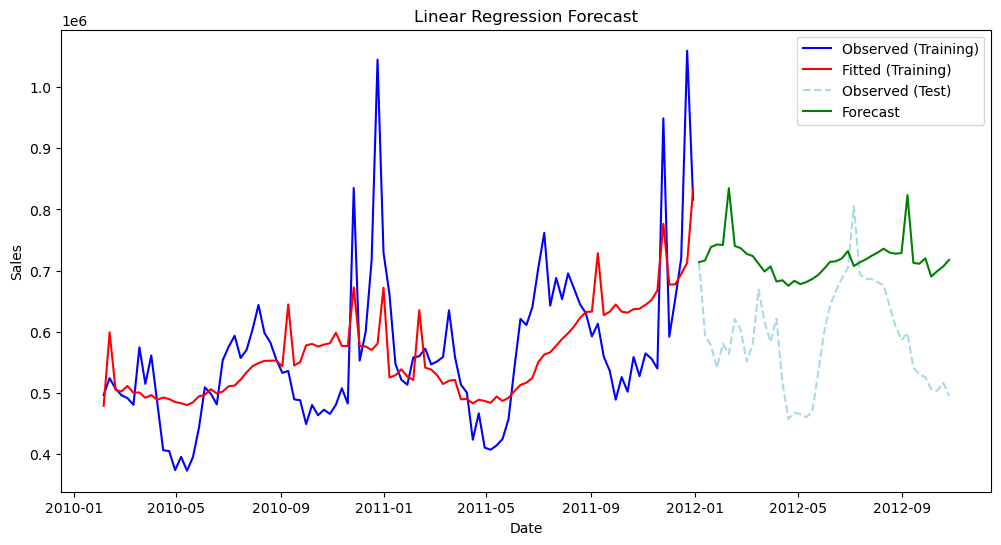

In [22]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

X_train = train_df[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y_train = train_df['Weekly_Sales']

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()

train_df['Fitted_Values'] = model.predict(X_train)

mae = mean_absolute_error(y_train, train_df['Fitted_Values'])
mse = mean_squared_error(y_train, train_df['Fitted_Values'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

print("\nModel Summary:")
print(model.summary())

forecast_steps = len(test_df)
forecast_index = test_df.index

X_future = test_df[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
X_future = sm.add_constant(X_future)

forecast = model.predict(X_future)

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df['Weekly_Sales'], label='Observed (Training)', color='blue')
plt.plot(train_df.index, train_df['Fitted_Values'], label='Fitted (Training)', color='red')

plt.plot(test_df.index, test_df['Weekly_Sales'], label='Observed (Test)', color='lightblue', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green')

plt.legend()
plt.title('Linear Regression Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.show()

# Monte Carlo Simulations

Product Adoption and Sales Bonus. Bianca Peterson is a marketing engineer for Hexagon Composites, a company which sells carbon composite storage tanks. In an effort to gain product adoptions from customers, Bianca goes on sales trips (often to foreign countries). For each of 120 previous sales trips, the file SalesTrips lists (1) whether the trip resulted in the visited customer adopting the product, and (2) the revenue generated by the adoption.

SalesTrips

a.Bianca has six sales trips planned over the next couple of months. What is the average revenue that Bianca expects to generatefrom these six trips? What is the probability that she generates $200,000 or less from these six trips?

b.Bianca receives a sales bonus if she gains three more product adoptions before the end of the year. The number of sales trips that Bianca will need to make to earn her bonus is uncertain. What is its distribution? If Bianca only has time to make 10 more sales trips before the end of the year, what is the likelihood that she earns her bonus?

In [23]:
np.random.seed(42)
n_simulations = 10000

np.random.seed(42)
revenues = np.random.normal(loc=50000, scale=10000, size=120)  # Mean $50,000, Std Dev $10,000

def simulate_revenue(n_trips, revenues):
    return np.random.choice(revenues, size=n_trips, replace=True).sum()

revenues_simulations = [simulate_revenue(6, revenues) for _ in range(n_simulations)]
avg_revenue = np.mean(revenues_simulations)
probability_less_than_200k = np.mean(np.array(revenues_simulations) <= 200000)

print(f"Average revenue expected from 6 trips: ${avg_revenue:.2f}")
print(f"Probability of generating $200,000 or less: {probability_less_than_200k:.4f}")

def trips_to_bonus(adoptions_needed, revenues):
    trips = 0
    adoptions = 0
    while adoptions < adoptions_needed:
        trips += 1
        if np.random.choice(revenues, size=1)[0] > 0:  # Simulating adoption success
            adoptions += 1
    return trips

bonus_simulations = [trips_to_bonus(3, revenues) for _ in range(n_simulations)]

probability_within_10_trips = np.mean(np.array(bonus_simulations) <= 10)

print(f"Probability of earning the bonus within 10 more trips: {probability_within_10_trips:.4f}")

Average revenue expected from 6 trips: $295198.65
Probability of generating $200,000 or less: 0.0000
Probability of earning the bonus within 10 more trips: 1.0000


# OPTIMIZATION PROBLEMS

In [24]:
import numpy as np
from scipy.optimize import minimize, brute, linprog
from scipy.optimize import milp, Bounds, LinearConstraint

## Mix integer linear problems

Problem statement:
Walmart needs to optimize inventory for Store A to maximize profit by determining the optimal order quantities for three products. Store A has specific demands of 180 units for Product 1, 120 units for Product 2, and 80 units for Product 3. The store’s total budget for inventory is $10,000, and it has a storage capacity of 300 units. Product 1 has a selling price of $50 per unit, a cost of $30, a holding cost of $2, and a fixed ordering cost of $100, with order limits ranging from 50 to 200 units. Product 2 is priced at $40 per unit, with a cost of $25, a holding cost of $1.5, and a fixed ordering cost of $80, and must be ordered between 40 and 150 units. Product 3 has a selling price of $30 per unit, a cost of $20, a holding cost of $1, and a fixed ordering cost of $60, with minimum and maximum order limits of 30 and 100 units, respectively. The objective is to maximize profit while ensuring that the total cost (including fixed ordering costs) does not exceed $10,000 and that the total number of units ordered does not exceed the store's storage capacity of 300 units.

Maximize total Profit:
     profit = (50*x1 + 40*x2 + 30*x3) - (30*x1 + 25*x2 + 20*x3) - (2*max([x1 - 180, 0]) + 1.5*max([x2 - 120, 0]) + 1*max([x3 - 80, 0])) - (100 + 80 + 60)
     
Constraints:
    50 <= x1 <= 200                                            order quantity constraints
    40 <= x2 <= 150      
    30 <= x3 <= 100
    30*x1 + 25*x1 + 20*x1 + 100 + 80 + 60 <= 10,000             budget constraints
    x1 + x2+ x3 <= 300                                          storage capacity

In [25]:
# negated the objective function to convert maximum into minimum
c = np.array([
    -(50 - 30 - 2),   # Profit per unit for Product 1
    -(40 - 25 - 1.5), # Profit per unit for Product 2
    -(30 - 20 - 1)    # Profit per unit for Product 3
])

# Coefficients for the constraints
A_ub = np.array([
    [30, 25, 20],     # Cost coefficients
    [1, 1, 1]         # Storage capacity constraint
])

b_ub = np.array([
    10000 - 100 - 80 - 60,          # Budget limit (total cost + fixed costs)
    300                             # Storage capacity limit
])

x_bounds = [(50, 200), (40, 150), (30, 100)]
bounds = [(low, high) for low, high in x_bounds]

result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

print("Status:", "Success" if result.success else "Failure")
print("Optimal Order Quantity for Product 1:", result.x[0])
print("Optimal Order Quantity for Product 2:", result.x[1])
print("Optimal Order Quantity for Product 3:", result.x[2])
print("Maximum Profit:", -result.fun)             # Negate the result to get the profit


Status: Success
Optimal Order Quantity for Product 1: 200.0
Optimal Order Quantity for Product 2: 70.0
Optimal Order Quantity for Product 3: 30.0
Maximum Profit: 4815.0


## Non Linear Production Optimization

A manufacturing company produces three types of products: A, B, and C. The company aims to maximize its profit while adhering to resource constraints. Each product requires a certain amount of resources and generates profit according to a nonlinear function, which reflects diminishing returns as production quantities increase.

For Product A, the profit function is given by Pa(Xa) = 10* Xa - 0.1* Xa^2, where Xa represents the quantity produced. Product B has a profit function of a Pb(Xb) = 15* Xb - 0.05* Xb^2, and Product C's profit function is Pc(Xc) = 20* Xc - 0.03* Xc^2, Here, 
Xb and Xc represent the quantities of Products B and C, respectively.

The company has a total of 1,000 resource units available. Each unit of Product A uses 2 resource units, Product B uses 3, and Product C uses 4. The production quantities for each product must fall within the following bounds: Product A should be produced between 0 and 100 units, Product B between 0 and 80 units, and Product C between 0 and 60 units.

The goal is to determine the optimal production quantities for Products A, B, and C that will maximize the total profit while not exceeding the resource limit and staying within the given bounds for each product. The problem involves solving a nonlinear optimization problem where the objective function and constraints are nonlinear in nature.

Objective Function:
    Maximize profit: (10*Xa - 0.1* Xa^2) + (15*Xb - 0.05* Xb^2) + (20*Xc - 0.03* Xc^2) 
    
Constraints: 
    2*Xa + 3*Xb + 4*Xc <= 1000              resource usage
    0 <= Xa <= 100
    0 <= Xb <= 80
    0 <= Xc <= 60

In [26]:
def objective(x):
    x_A, x_B, x_C = x
    profit_A = 10 * x_A - 0.1 * x_A**2
    profit_B = 15 * x_B - 0.05 * x_B**2
    profit_C = 20 * x_C - 0.03 * x_C**2
    return -(profit_A + profit_B + profit_C)

def constraint(x):
    x_A, x_B, x_C = x
    return 1000 - (2 * x_A + 3 * x_B + 4 * x_C)

x0 = [50, 40, 30]

bounds = [(0, 100), (0, 80), (0, 60)]

constr = {'type': 'ineq', 'fun': constraint}

result = minimize(objective, x0, bounds=bounds, constraints=constr, method='SLSQP')

print("Status:", "Success" if result.success else "Failure")
print("Optimal Production Quantity for Product A:", result.x[0])
print("Optimal Production Quantity for Product B:", result.x[1])
print("Optimal Production Quantity for Product C:", result.x[2])
print("Maximum Profit:", -result.fun)  # Negate the result to get the profit


Status: Success
Optimal Production Quantity for Product A: 50.0
Optimal Production Quantity for Product B: 80.0
Optimal Production Quantity for Product C: 60.0
Maximum Profit: 2222.0


## Binary Problem statement

Walmart is considering opening new distribution centers in six potential locations. Each location has a fixed opening cost and offers different profit contributions. The fixed costs and profit contributions for each location are as follows: Location 1 ($300,000 cost, $900,000 profit), Location 2 ($250,000 cost, $750,000 profit), Location 3 ($280,000 cost, $800,000 profit), Location 4 ($350,000 cost, $1,000,000 profit), Location 5 ($270,000 cost, $780,000 profit), and Location 6 ($320,000 cost, $850,000 profit). With a total budget of $1,200,000, Walmart needs to decide which centers to open to maximize total profit. Each decision is binary: a center is either opened (1) or not (0). The goal is to find the optimal combination of centers to open while staying within the budget.

In [27]:
costs = np.array([300000, 250000, 280000, 350000, 270000, 320000])  # cost of opening per location

profits = np.array([900000, 750000, 800000, 1000000, 780000, 850000])  # profits per locations

budget = 1200000       # Total available budget

# negate it to convert maximum problem to minimum
c = -profits 

# Constraint:
A = np.array([costs])  # budget constraints

b_l = np.array([0])   
b_u = np.array([budget])

bounds = Bounds(0, 1)  
constraints = LinearConstraint(A, b_l, b_u)

integrality = np.ones_like(c, dtype=int)  

result = milp(c=c, bounds=bounds, constraints=constraints, integrality=integrality)

if result.success:
    print("Optimal solution:")
    print(f"Objective value (Total Profit): {-result.fun}")  # Negate the result to get the positive profit
    print("Variable values (0 means not open, 1 means open):")
    for i, value in enumerate(result.x):
        print(f"Location {i + 1}: {int(value)}")
else:
    print("No optimal solution found.")
    print("Status:", result.message)

Optimal solution:
Objective value (Total Profit): 3480000.0
Variable values (0 means not open, 1 means open):
Location 1: 1
Location 2: 0
Location 3: 1
Location 4: 1
Location 5: 0
Location 6: 0
